In [823]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage import measure

In [824]:
# Display image
def display(images, titles, Axis=False, Plot=False, Gray=False):
    fig, axes = plt.subplots(1, len(images), figsize=(18, 5))

    for ax, img, title in zip(axes, images, titles):
        if Plot:
            ax.plot(img)
        else:
            if Gray:
                ax.imshow(img, cmap="gray")
            else:
                ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        ax.set_title(title)

    if not Axis: 
        for ax in axes: ax.axis('off')

    plt.show()

Processing input images

In [825]:
def thresholdSegmentation(image, lower_threshold, upper_threshold = 255, min_size = 500, colorFilter = np.array([])):
    img = image.copy()

    if colorFilter.size:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, colorFilter[0], colorFilter[1])
        mask_inv = cv2.bitwise_not(mask)
        img = cv2.bitwise_and(img, img, mask=mask_inv)

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Intensity threshold
    _, binary_image = cv2.threshold(gray_img, lower_threshold, upper_threshold, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # binary morphological operation
    close_img = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    open_image = cv2.morphologyEx(close_img, cv2.MORPH_OPEN, kernel)

    # remove boundary objects
    contours, _ = cv2.findContours(open_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(open_image)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x == 0 or y == 0 or x + w == open_image.shape[1] or y + h == open_image.shape[0]:
            cv2.drawContours(mask, [contour], -1, 255, -1)

    reconstructed = cv2.bitwise_and(open_image, mask)
    boundary_removed_image = cv2.subtract(open_image,  reconstructed)

    # Filter segments
    labels = measure.label(boundary_removed_image, connectivity=1)
    properties = measure.regionprops(labels)
    final_image = np.zeros_like(boundary_removed_image)

    for prop in properties:
        if prop.area >= min_size:
            final_image[labels == prop.label] = 255
    # Count segments
    labels = measure.label(final_image, connectivity=1)
    num_objects = len(np.unique(labels)) - 1

    # Return values
    return final_image, f"n = {num_objects}"

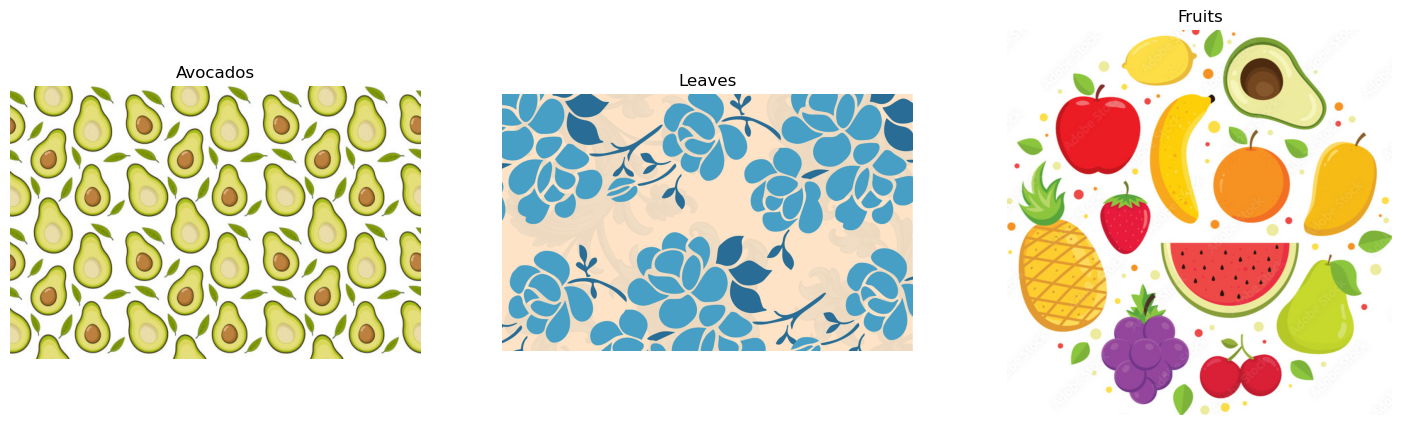

In [826]:
img1 = cv2.imread('Avocados.jpg')
img2 = cv2.imread('Leaves.png')
img3 = cv2.imread('Fruits.jpg')

origns = [img1, img2, img3]
titles = ['Avocados','Leaves','Fruits']
display(origns, titles)

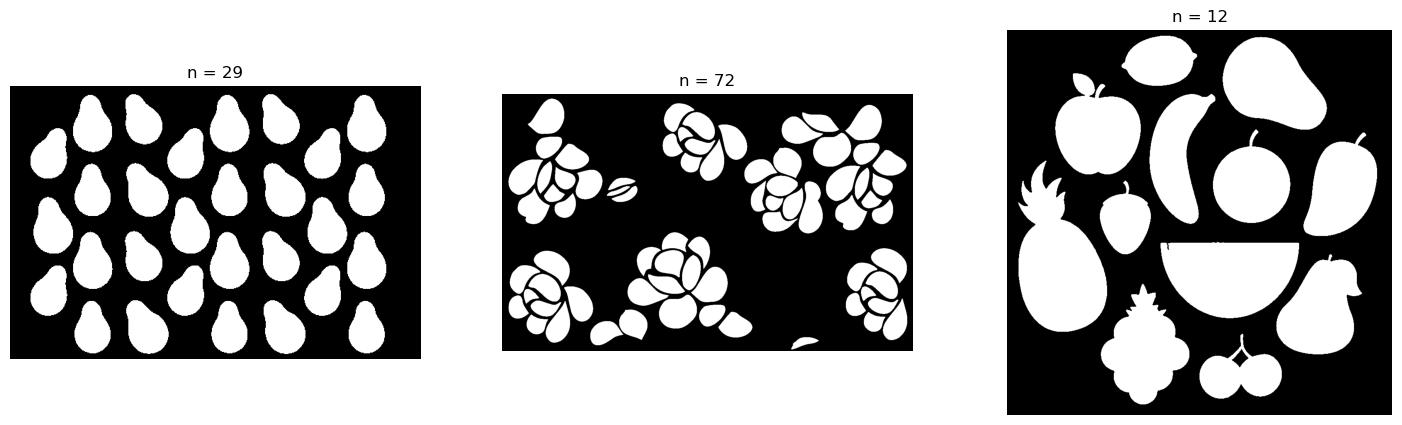

In [828]:
colorFilter = np.array([[90, 40, 150], [110, 255, 255]])

res_img1, cnt1 = thresholdSegmentation(img1, 220)
res_img2, cnt2 = thresholdSegmentation(img2, 10, colorFilter=colorFilter)
res_img3, cnt3 = thresholdSegmentation(img3, 242, min_size=2000)

res = [res_img1, res_img2, res_img3]
res_titles = [cnt1, cnt2, cnt3]

display(res, res_titles, Gray=True)